#Instalar Librerias

In [ ]:
import numpy as np
from IPython.display import display, Latex
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from scipy import signal
#from scipy import fftpack
from importlib import reload
from scipy import stats

#PARA LAS SEÑALES DE MATLAB
import scipy.io as sio

import csv

import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn import svm

import re

import math as mt

#import itertools

#from gapminder import gapminder

from pprint import pprint

import seaborn as sn

from itertools import combinations,product

from imageio import imread, imwrite
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Montar Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Ejercicio 1:

##Codigo

###Crear Datos TP3-1

In [ ]:
def crear_datos(m_hp,b_hp,M,L,N): #recta hiperplano -> y = m_hp * x + b_hp; M: margen; L: limite de x e y; n_c1: cantidad de puntos de la clase 1; n_c2: cantidad de puntos de la clase 2
  fs = 100
  x_vec = np.arange(0,L,L/fs)
  y_hp = m_hp * x_vec + b_hp
  m_sup = y_hp + M
  m_inf = y_hp - M
  x_c1 = []
  y_c1 = []
  x_c2 = []
  y_c2 = []
  i = 0
  while x_c1 == [] or x_c2 == []:
    while i < N:
      x_i = np.random.uniform(0,L)
      y_i = np.random.uniform(0,L)
      if m_hp * x_i + b_hp + M < y_i:#clase 1
        x_c1.append(x_i)
        y_c1.append(y_i)
        i += 1
      elif m_hp * x_i + b_hp - M > y_i:#clase 2
        x_c2.append(x_i)
        y_c2.append(y_i)
        i += 1
  
  data = pd.DataFrame(columns = ['x','y','clase'])
  data.iloc[:,0] = x_c1 + x_c2 
  data.iloc[:,1] = y_c1 + y_c2
  data.iloc[:,2] = np.concatenate((np.ones(len(x_c1),dtype=int) , np.ones(len(x_c2),dtype=int)*(-1)))
  
  return x_vec, y_hp, m_sup, m_inf, data

In [ ]:
def graficar_datos(L, data, x_vec = 0, hp = False, y_hp = 0 , m = False, m_sup = 0, m_inf = 0, per = False, w = 0, opt = False, w_opt = 0, w_margen_sup = 0, w_margen_inf = 0):
  x_c1 = data.loc[data['clase'] == 1, 'x']
  x_c2 = data.loc[data['clase'] == -1, 'x']
  y_c1 = data.loc[data['clase'] == 1, 'y']
  y_c2 = data.loc[data['clase'] == -1, 'y']

  plt.figure(figsize = [12,7]) 

  plt.scatter(x_c1,y_c1,color='red')
  plt.scatter(x_c2,y_c2,color='blue')
  labels = []

  if hp:
    plt.plot(x_vec, y_hp, 'k--')
    labels.append('Hiperplano de separacion')

  if m:
    plt.plot(x_vec, m_sup, 'g--')
    plt.plot(x_vec, m_inf, 'g--')
    labels.append('Margenes')


  if per: 
    y_per = (-w[0] - w[1] * x_vec)/w[2]
    plt.plot(x_vec, y_per, 'y--')
    labels.append('Perceptron simple')
  
  if opt:
    y_opt = (-w_opt[0] - w_opt[1] * x_vec)/w_opt[2]
    y_margen_sup = (-w_margen_sup[0] - w_margen_sup[1] * x_vec)/w_margen_sup[2]
    y_margen_inf = (-w_margen_inf[0] - w_margen_inf[1] * x_vec)/w_margen_inf[2] 
    plt.plot(x_vec, y_opt, 'm--')
    plt.plot(x_vec, y_margen_sup, 'g--')
    plt.plot(x_vec, y_margen_inf, 'g--')
    labels.append('Hiperplano calculado')
    labels.append('Margenes')
  
  plt.legend(labels)
  plt.ylim((0,L))
  plt.xlim((0,L))

###Perceptron Simple

In [ ]:
def calcular_error(train,w):
  error = 0
  for i in range(len(train)):
    excitacion = w[0] + train.iloc[i,0]*w[1] + train.iloc[i,1]*w[2]
    activacion = int(np.sign(excitacion))# 0,1,-1
    if activacion == 0: 
      #activacion = train['clase'].mode()[0]
      activacion = -1

    if train.iloc[i,2] != activacion:#clase predicha
      error += 1
    
  return error

In [ ]:
def perceptron_simple(train,fp,cota): 
  i = 0
  w = np.zeros(3) 
  error = 1
  error_min = len(train)*2
  pred = []
  while (error > 0 and i < cota):
    #Elegir al azar un ejemplo (x,y) siendo su salida deseada clase
    index_rand = int(np.random.uniform(0, len(train)))
    x = train.iloc[index_rand,0]
    y = train.iloc[index_rand,1]

    excitacion = w[0] + x*w[1] + y*w[2]#producto interno
    activacion = int(np.sign(excitacion))# 0,1,-1
    if activacion == 0: 
      activacion = train['clase'].mode()[0]
    
    delta_w = fp * (train.iloc[index_rand,2] - activacion)
    w[0] = w[0] + delta_w
    w[1] = w[1] + delta_w * x
    w[2] = w[2] + delta_w * y

    error = calcular_error(train,w)

    if error < error_min: 
      error_min = error
      w_min = w
    i += 1
  
  return w_min

###Hiperplano optimo

In [ ]:
def distancia_perceptron(train,w,k):
  #separo en dos dataframe por clase
  c1 = train.loc[train['clase']==1]
  c2 = train.loc[train['clase']==-1]

  #calculo las ditancias a la recta de cada clase
  d1 = abs((1/(mt.sqrt(w[1]**2 + w[2]**2))) * (w[0] + c1['x']*w[1] + c1['y']*w[2]))
  d2 = abs((1/(mt.sqrt(w[1]**2 + w[2]**2))) * (w[0] + c2['x']*w[1] + c2['y']*w[2]))

  #chequeo que haya k puntos en cada clase
  if len(c1) < k or len(c2) < k:
    k = min(len(c1),len(c2))

  #agrego las distancias al dataframe
  c1.loc[c1.index,'distancia'] = d1
  c2.loc[c2.index,'distancia'] = d2

  #ordeno el dataframe por distancias
  c1 = c1.sort_values(by='distancia')
  c2 = c2.sort_values(by='distancia')

  #saco la fila distancias
  c1 = c1.drop('distancia',axis=1)
  c2 = c2.drop('distancia',axis=1)

  #me quedo con los k primeros valores que van a ser los de la minima distancia
  c1 = c1.head(k)
  c2 = c2.head(k)

  return c1,c2 # dataframe con coordenadas y clase de los k puntos cercanos

In [ ]:
def candidato_hp(p_2,p_1,train):
  #obtenemos cada coordenada de los puntos que ingresan en la funcion
  #p_2
  x_1 = train.loc[p_2[0],'x']
  y_1 = train.loc[p_2[0],'y']
  x_2 = train.loc[p_2[1],'x']
  y_2 = train.loc[p_2[1],'y']
  
  #p_1
  x_3 = train.loc[p_1,'x']
  y_3 = train.loc[p_1,'y']
  
  #trazamos una recta entre los 2 puntos de la misma clase
  m_r1 = (y_1 - y_2)/(x_1 - x_2)
  b_r1 = y_1 - m_r1*x_1

  #trazamos a una recta perpendicular a la anterior que ademas pase por el punto restante
  m_r2 = -(1/m_r1)
  b_r2 = y_3 - m_r2*x_3

  #calculamos el punto de interseccion entre las dos rectas
  x_inter = (b_r2 - b_r1)/(m_r1 - m_r2)
  y_inter = m_r1 * x_inter + b_r1
  
  #calculamos la distancia entre el punto de interseccion y el punto restante
  d = mt.sqrt((x_inter - x_3)**2 + (y_inter - y_3)**2)

  #trazamos una recta que pase por el punto medio entre el punto de interseccion y el punto restante con la misma pendiente de la recta 1
  b_hp = (y_inter + y_3)/2 - m_r1*(x_inter + x_3)/2
  w_hp = [-b_hp, -m_r1, 1]

  #se trazan los margenes de lan recta (que son la recta de los dos puntos y una recta de igual pendiente que pase por el punto restante)
  w_margen_sup = [b_r1, m_r1, -1]
  b_inf = y_3 - m_r1*x_3
  w_margen_inf = [b_inf, m_r1, -1]

  #se chequea que ningun punto este dentro de los margenes, si hay puntos se descarta la recta como candidata a ser la recta optima
  for i in range(len(train)):
    x_i = train.iloc[i,0]
    y_i = train.iloc[i,1]
    if (x_i != x_1 and x_i != x_2 and x_i != x_3): 
      d_i = (1/(mt.sqrt(w_hp[1]**2 + w_hp[2]**2))) * abs((w_hp[0] + x_i*w_hp[1] + y_i*w_hp[2]))

      if d_i < d/2:
        d = 0
        break

  return w_hp,w_margen_sup,w_margen_inf,d

In [ ]:
def hp_optimo(train,w,k,x_vec,L):#train tiene coordenadas y clase; w es la recta de perceptron; k es el numero de puntos que se eligiran mas cercanos
  #calcular distancias de todos los puntos a perceptron y elegir los k puntos con menor distancia
  c1,c2 = distancia_perceptron(train,w,k)

  comb1 = list(combinations(c1.index,2))
  comb2 = list(combinations(c2.index,2))
  c = [c1.index,c2.index]
  comb  = [comb2,comb1]

  d_opt = 0
  w_opt = []
  w_margen_sup_opt = []
  w_margen_inf_opt = []

  error_per = calcular_error(train,w)

  #para todas las combinaciones posibles de 2 puntos de una clase y 1 de otra y calculo la recta candidata a ser el hiperplano optimo
  for i in range(2):
    for j in range(len(comb[i])):
      for o in range(len(c[i])):
        #calculo la posible recta, los margenes y la distancia entre margenes
        w_hp,w_margen_sup,w_margen_inf,d = candidato_hp(comb[i][j],c[i][o],train)
        
        #calculo el error para ese hiperplano
        error_hp = calcular_error(train,w_hp)
        #print('error = ',error_hp)
        #plt.figure()
        graficar_datos(L, train, x_vec, per = True, w = w,opt = True, w_opt = w_hp, w_margen_sup = w_margen_sup, w_margen_inf = w_margen_inf)
        plt.title('error = ' + str(error_hp))
        #me quedo con la mayor distancia entre margenes posible
        if d > d_opt and error_hp <= error_per:
          d_opt = d
          w_opt = w_hp
          w_margen_sup_opt = w_margen_sup
          w_margen_inf_opt = w_margen_inf

  plt.figure()      
  graficar_datos(L, train, x_vec, per = True, w = w,opt = True, w_opt = w_opt, w_margen_sup = w_margen_sup_opt, w_margen_inf = w_margen_inf_opt)
  plt.title('Hiperplano optimo. ' + 'Error = ' + str(error_hp))
  return w_opt,w_margen_sup_opt,w_margen_inf_opt

###Crear Datos TP3-2

In [ ]:
def crear_datos2(m_hp,b_hp,M,L,N): #recta hiperplano -> y = m_hp * x + b_hp; M: margen; L: limite de x e y; n_c1: cantidad de puntos de la clase 1; n_c2: cantidad de puntos de la clase 2
  fs = 100
  x_vec = np.arange(0,L,L/fs)
  y_hp = m_hp * x_vec + b_hp
  m_sup = y_hp + M
  m_inf = y_hp - M
  x_c1 = []
  y_c1 = []
  x_c2 = []
  y_c2 = []
  i = 0
  j = 0
  k = 0
  while x_c1 == [] or x_c2 == [] or j == 0 or k == 0:
    while i < N:
      x_i = np.random.uniform(0,L)
      y_i = np.random.uniform(0,L)
      if (m_hp * x_i + b_hp + M < y_i):#clase 1
        x_c1.append(x_i)
        y_c1.append(y_i)
        i += 1
      elif (m_hp * x_i + b_hp - M > y_i):#clase 2
        x_c2.append(x_i)
        y_c2.append(y_i)
        i += 1
      elif (m_hp * x_i + b_hp - M < y_i < m_hp * x_i + b_hp):#clase 1 mal clasificados
        x_c1.append(x_i)
        y_c1.append(y_i)
        i += 1
        j += 1
      elif (m_hp * x_i + b_hp < y_i < m_hp * x_i + b_hp + M):#clase 2 mal clasificados
        x_c2.append(x_i)
        y_c2.append(y_i)
        i += 1
        k += 1
  
  data = pd.DataFrame(columns = ['x','y','clase'])
  data.iloc[:,0] = x_c1 + x_c2 
  data.iloc[:,1] = y_c1 + y_c2
  data.iloc[:,2] = np.concatenate((np.ones(len(x_c1),dtype=int) , np.ones(len(x_c2),dtype=int)*(-1)))

  return x_vec, y_hp, m_sup, m_inf, data

###SVM

In [ ]:
def fun_svm(data, kernel_svm = 'rbf', grado_poly = 3, C_svm = 1, max_iter = 1000, graficar_2D = False):
  coordenadas = data.copy()
  coordenadas = coordenadas.drop('clase',axis=1)
  clases = data['clase']

  clasificador_svm = svm.SVC(C = C_svm,kernel=kernel_svm, degree = grado_poly,max_iter = max_iter)
  clasificador_svm = clasificador_svm.fit(coordenadas,clases)

  if graficar_2D:
    fig, ax = plt.subplots(figsize = [12,7])
    # Create grid to evaluate model
    xx = np.linspace(-1, max(coordenadas['x']) + 1, len(coordenadas))
    yy = np.linspace(0, max(coordenadas['y']) + 1, len(clases))
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    # Assigning different colors to the classes
    colors = clases
    colors = np.where(colors == 1, 'r', 'b')
    # Plot the dataset
    ax.scatter(coordenadas['x'], coordenadas['y'], c=colors)
    # Get the separating hyperplane
    Z = clasificador_svm.decision_function(xy).reshape(XX.shape)
    # Draw the decision boundary and margins
    ax.contour(XX, YY, Z, colors=['g','k','g'], levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    # Highlight support vectors with a circle around them
    ax.scatter(clasificador_svm.support_vectors_[:, 0], clasificador_svm.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='none')
    if kernel_svm == 'poly':
      plt.title('SVM con C = ' + str(C_svm) + ' y kernel = "' + kernel_svm + '" de grado ' + str(grado_poly))
    else:
      plt.title('SVM con C = ' + str(C_svm) + ' y kernel = "' + kernel_svm + '"')
    plt.show()

  return clasificador_svm

##Resolución 

###Resuelva los siguientes ítems:

###a) Construya un conjunto 'TP3-1' de ejemplos linealmente separables en R^2 (por ejemplo, en forma aleatoria, genere puntos en [0; 5]x[0; 5] tal que pertenezcan a dos clases linealmente separables 1 y -1). Utilice un perceptron simple escalón para separar al conjunto linealmente. ¿El hiperplano de separación es óptimo? Justifique la respuesta.

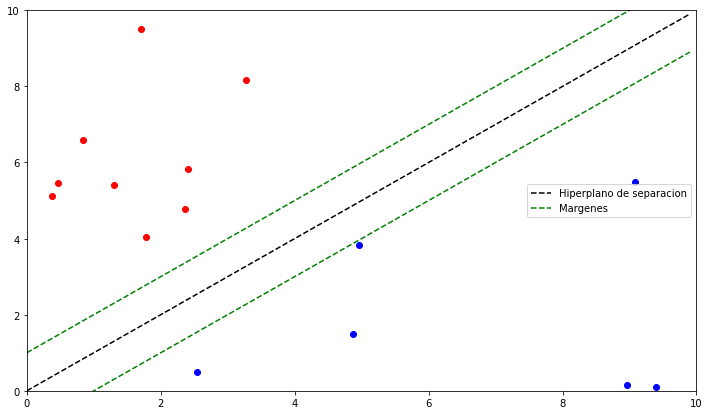

In [ ]:
#Creamos las dos clases
M = 1
L = 10
N = 15
x_vec, y_hp, m_sup, m_inf, data1 = crear_datos(1,0,M,L,N)
graficar_datos(L, data1, x_vec,True, y_hp ,True, m_sup, m_inf)

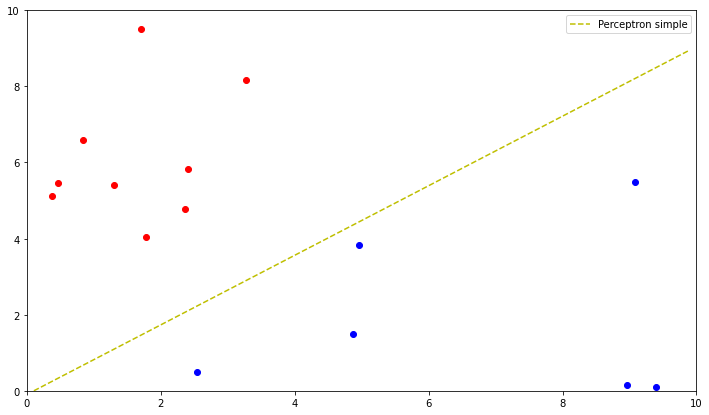

In [ ]:
#aplicamos el algoritmo perceptron simple
fp = 0.1
cota = 100*len(data1)
w = perceptron_simple(data1,fp,cota)
graficar_datos(L, data1, x_vec, per = True, w = w)

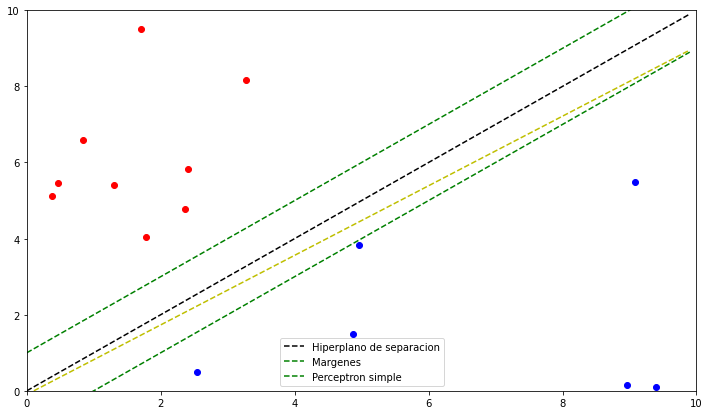

In [ ]:
#graficamos el hiperplano inicial y el hiperplano generado por perceptron simple
graficar_datos(L, data1, x_vec,True, y_hp ,True, m_sup, m_inf, per = True, w = w)

###b) Obtener el hiperplano óptimo a partir del hiperplano que obtuvo con el perceptron simple.

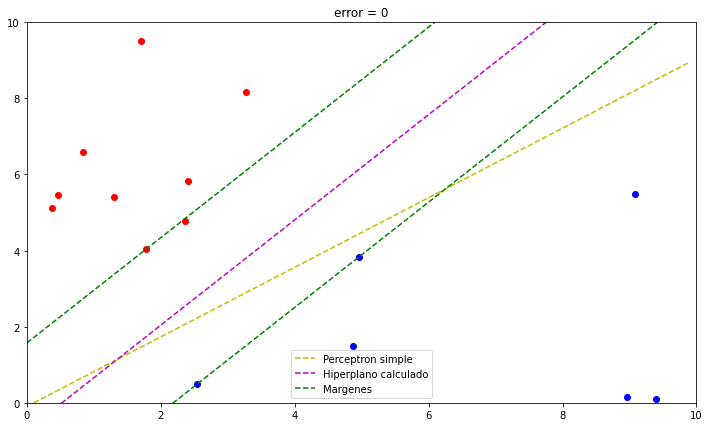

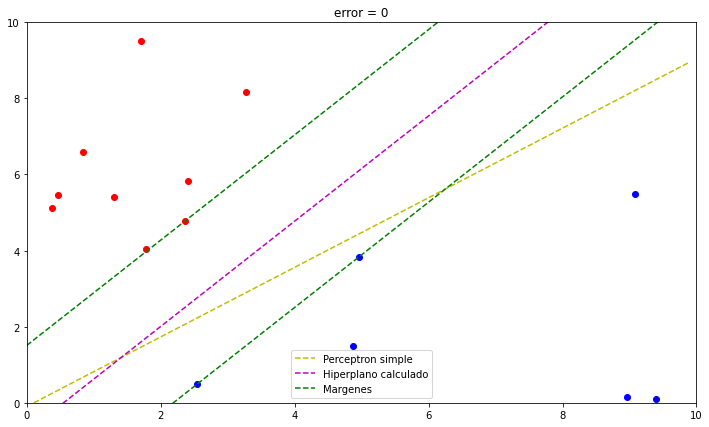

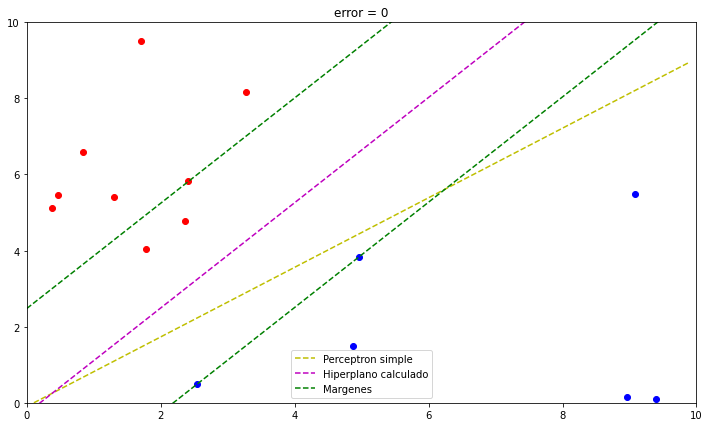

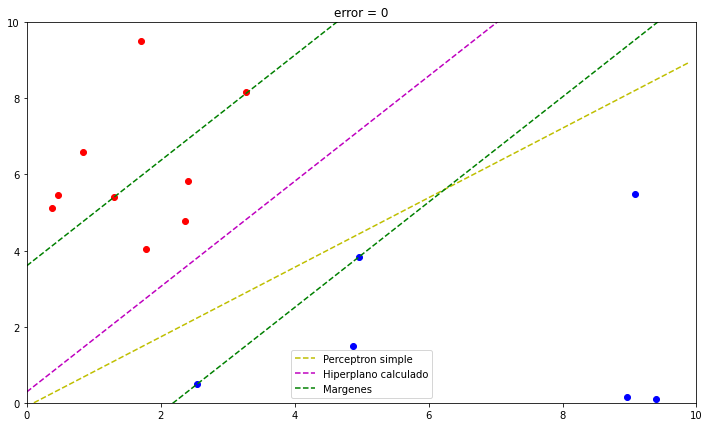

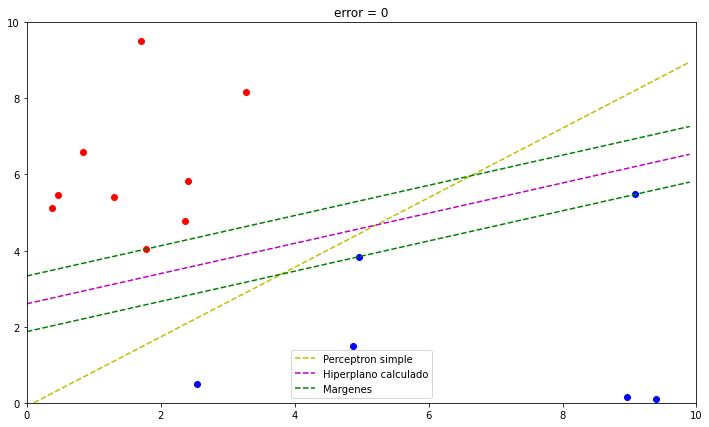

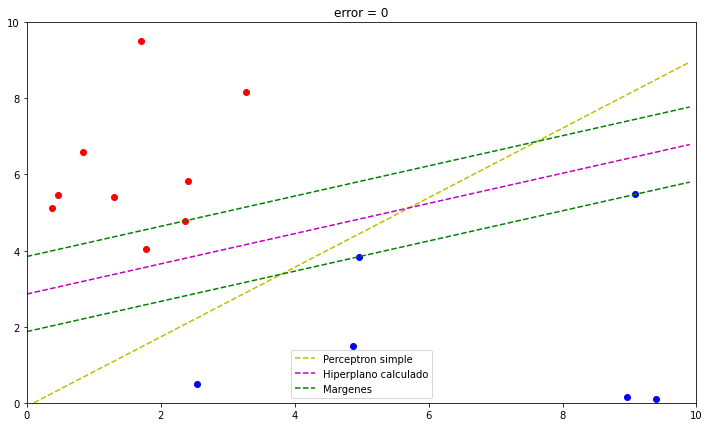

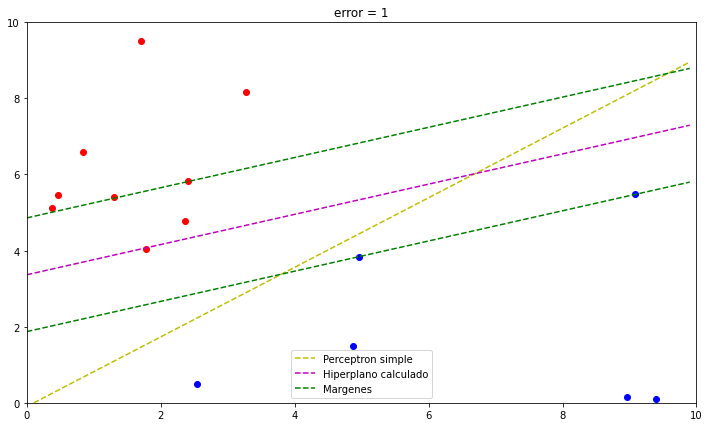

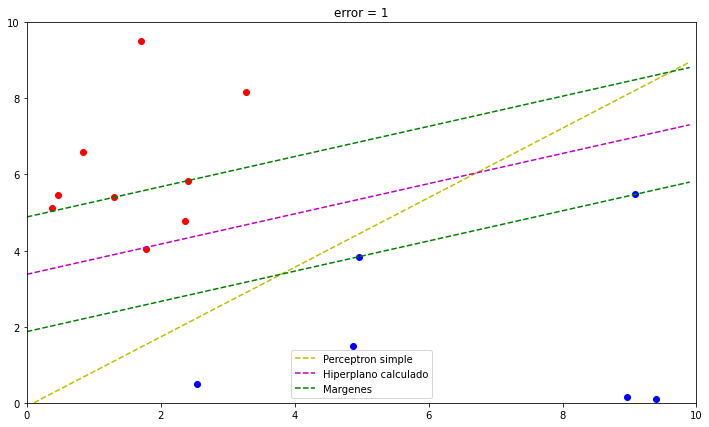

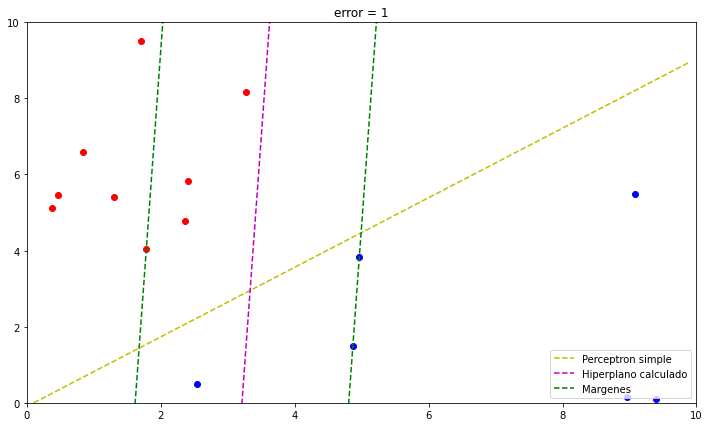

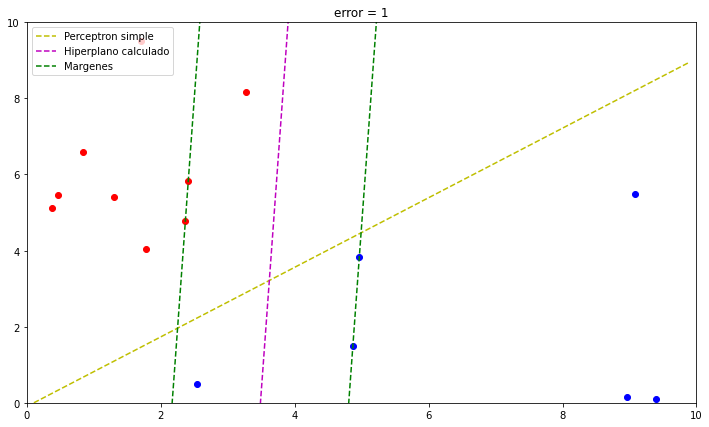

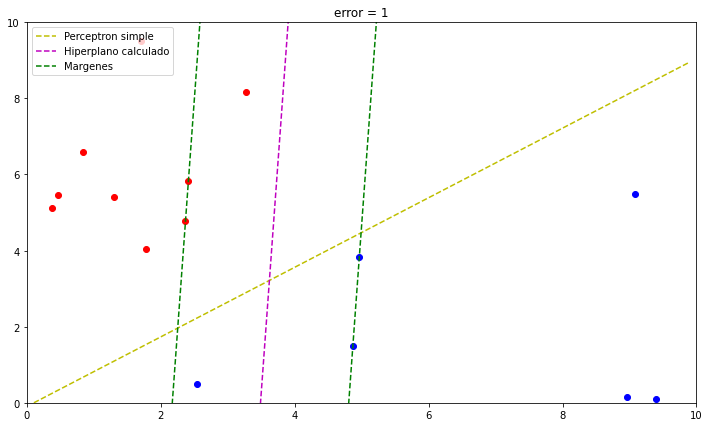

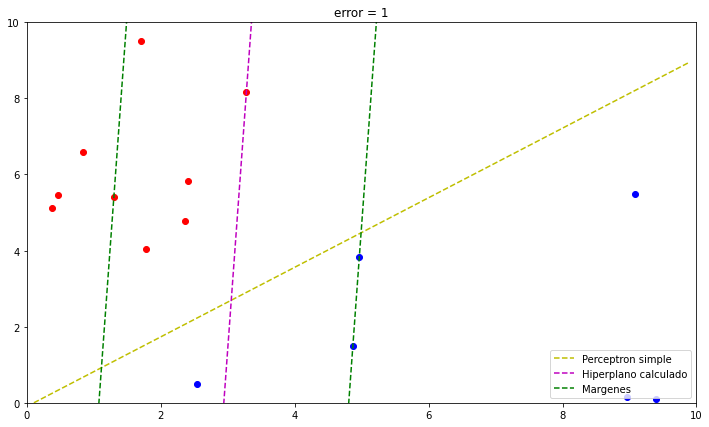

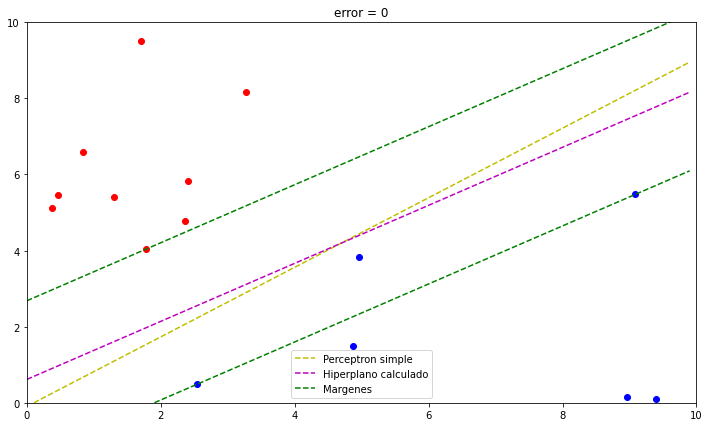

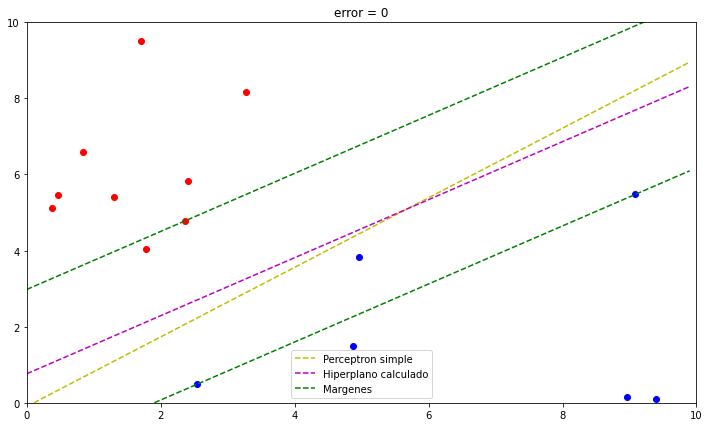

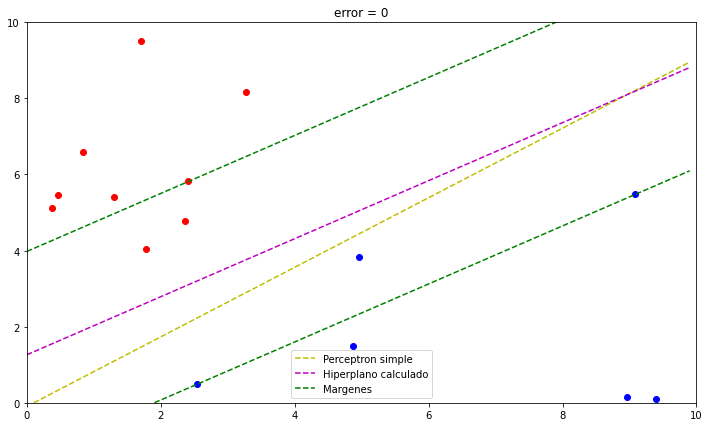

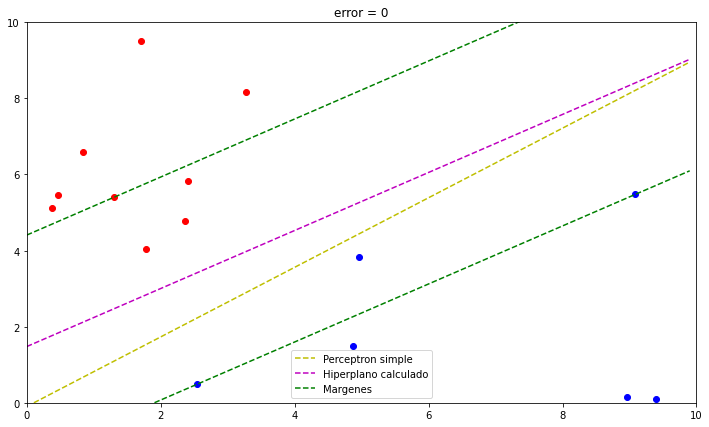

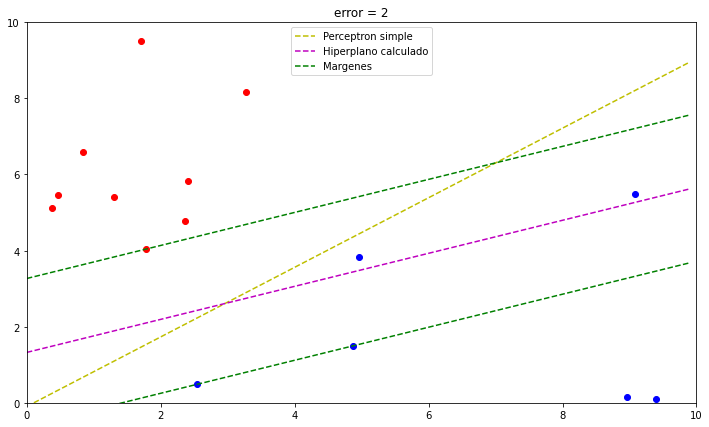

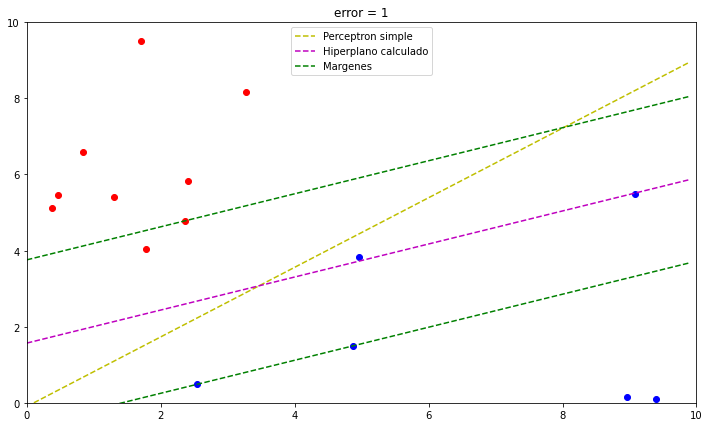

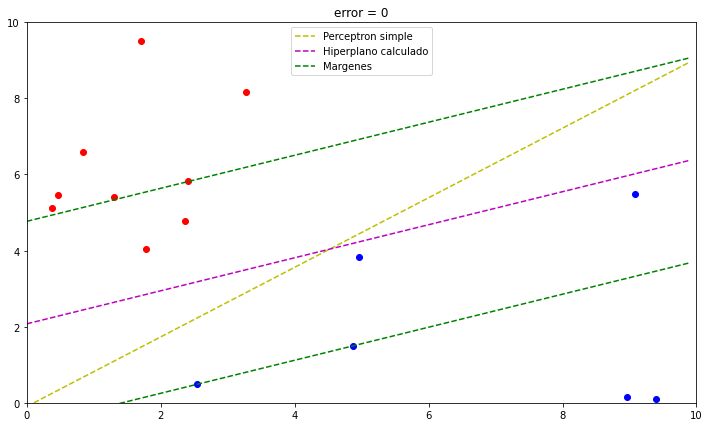

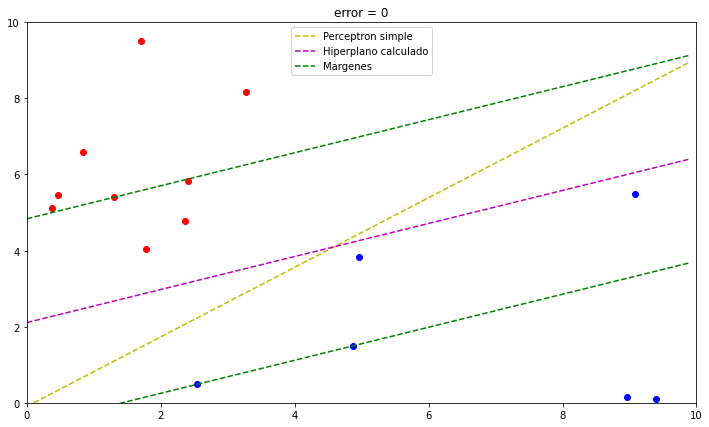

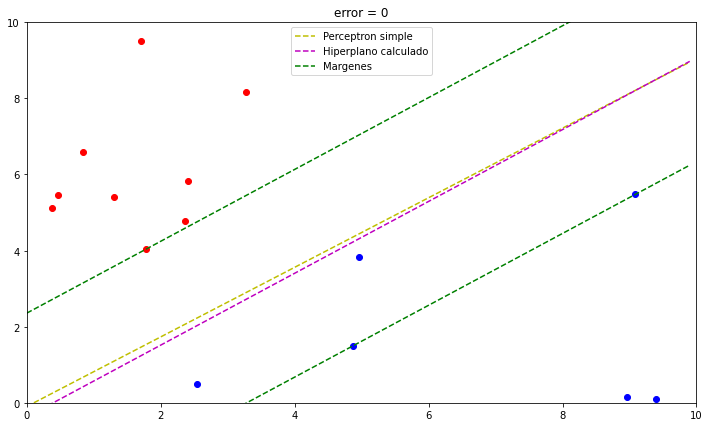

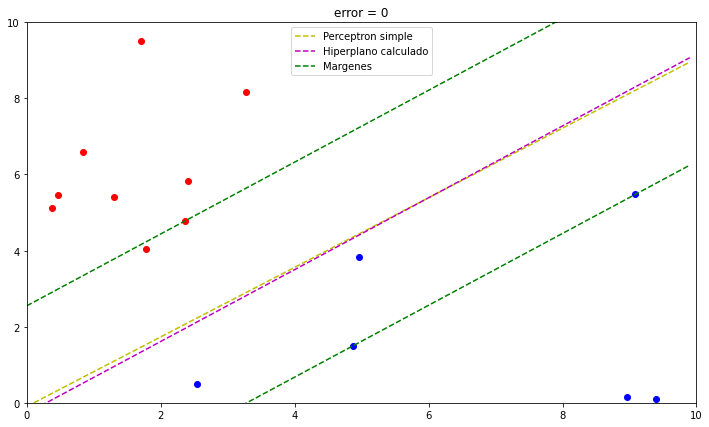

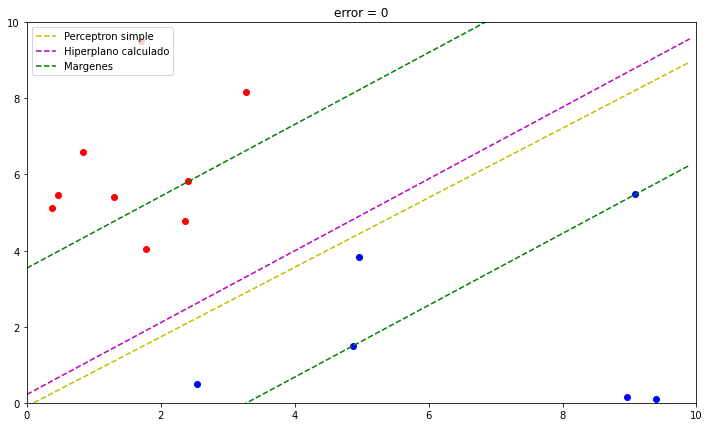

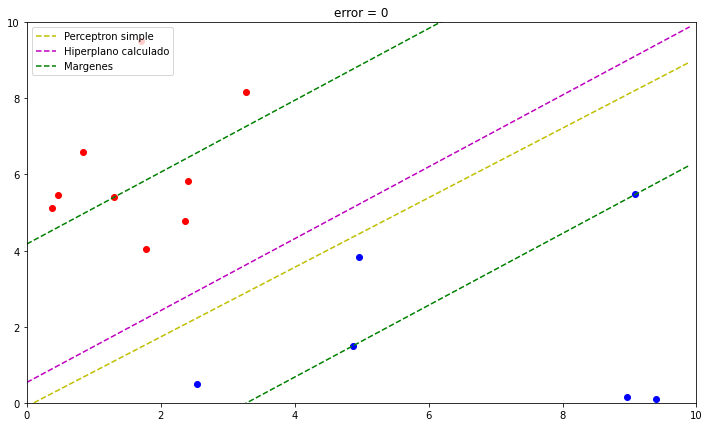

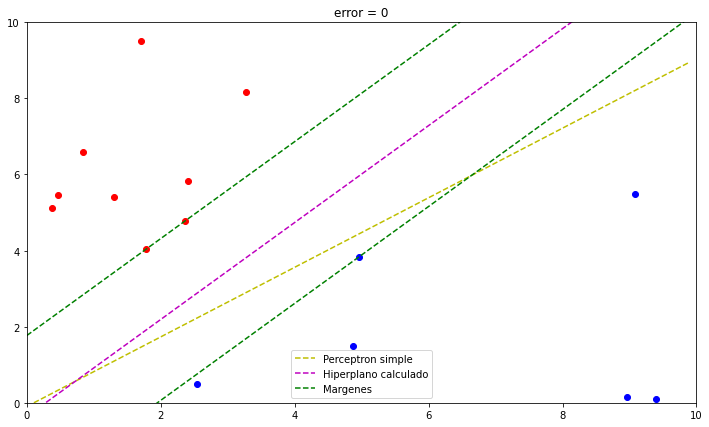

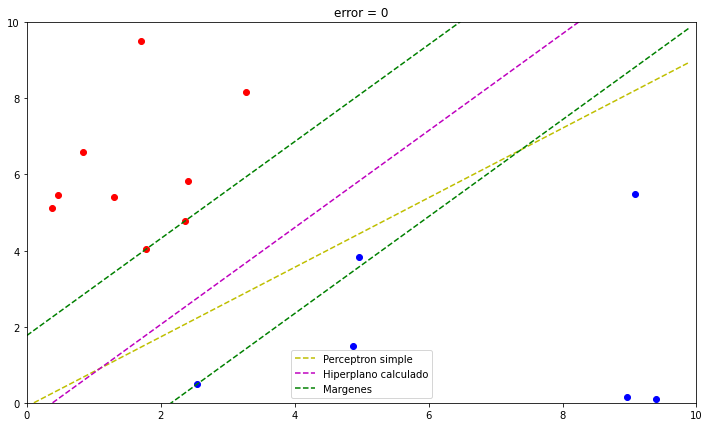

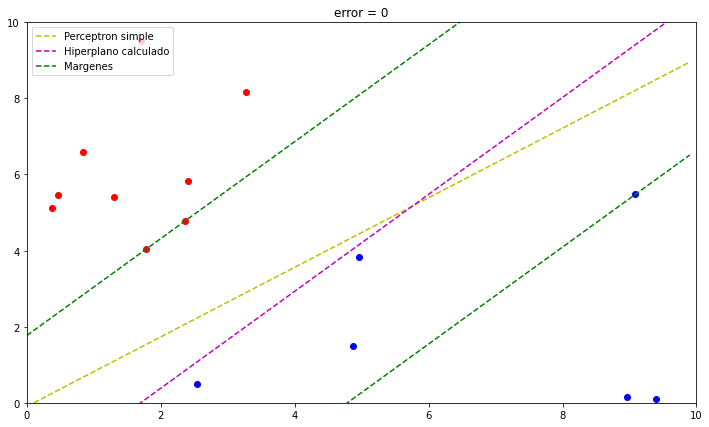

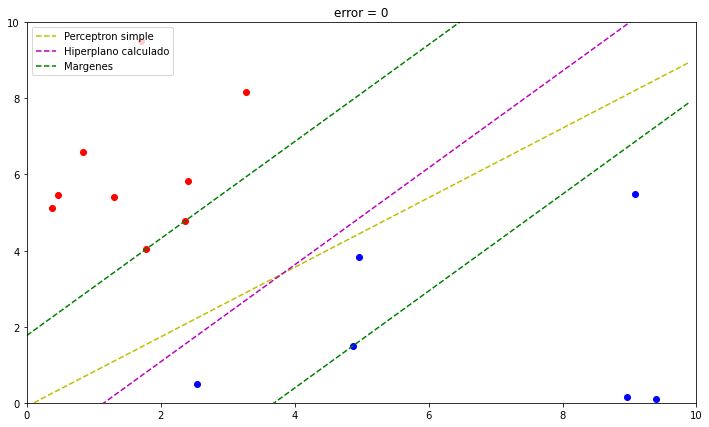

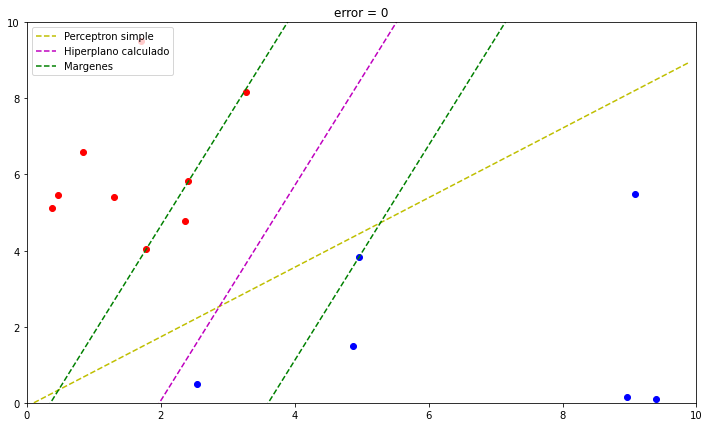

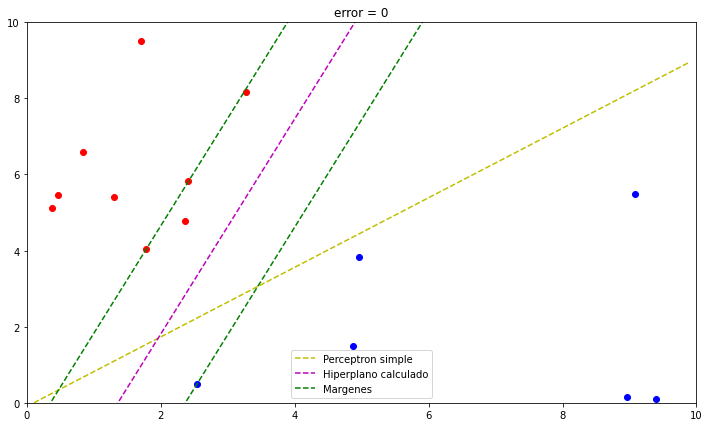

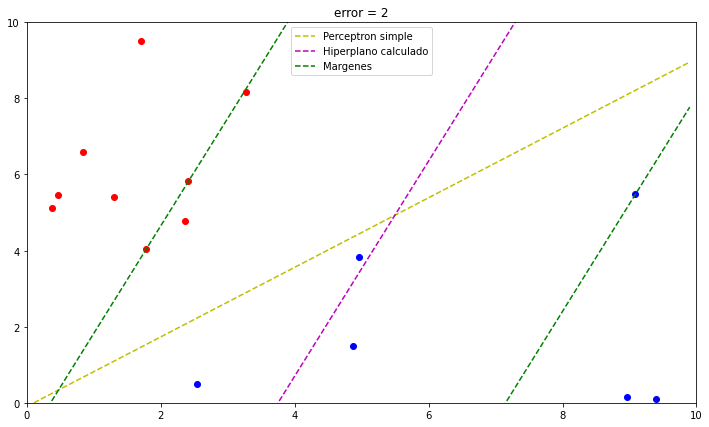

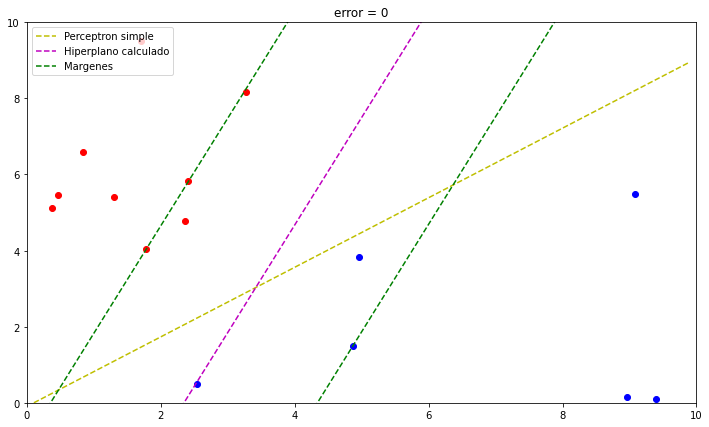

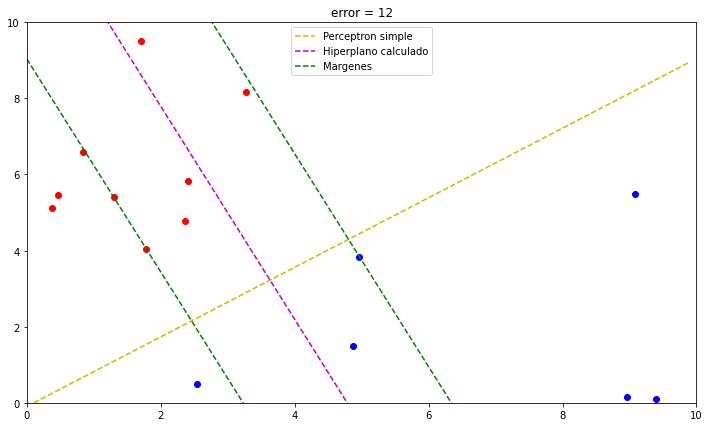

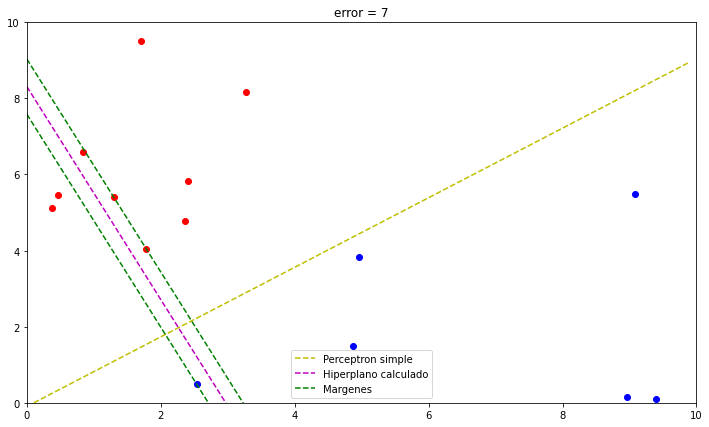

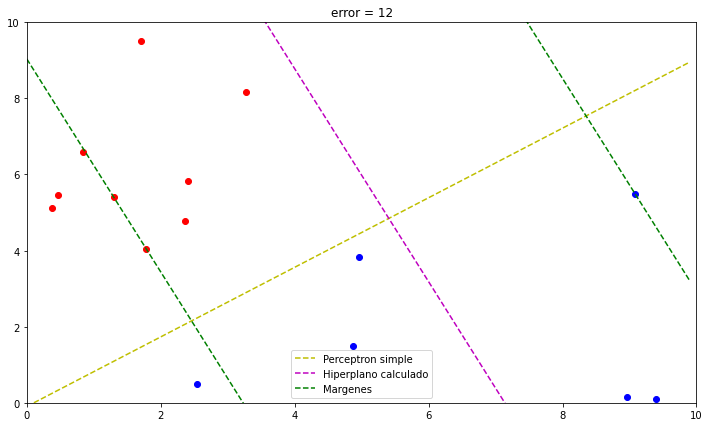

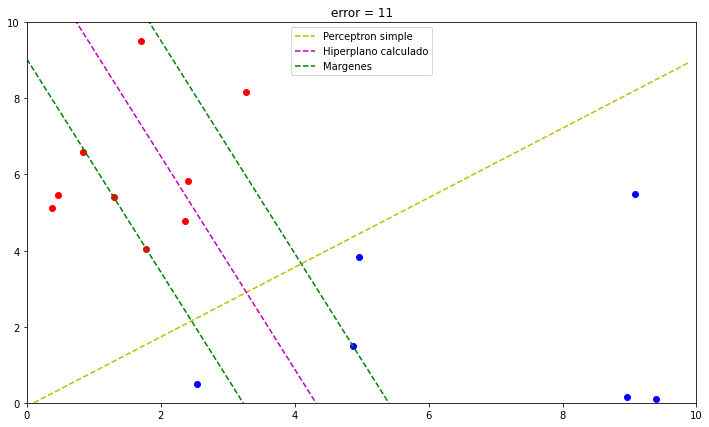

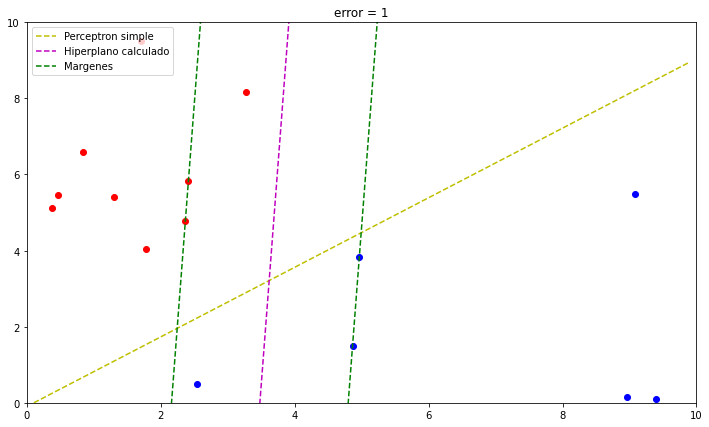

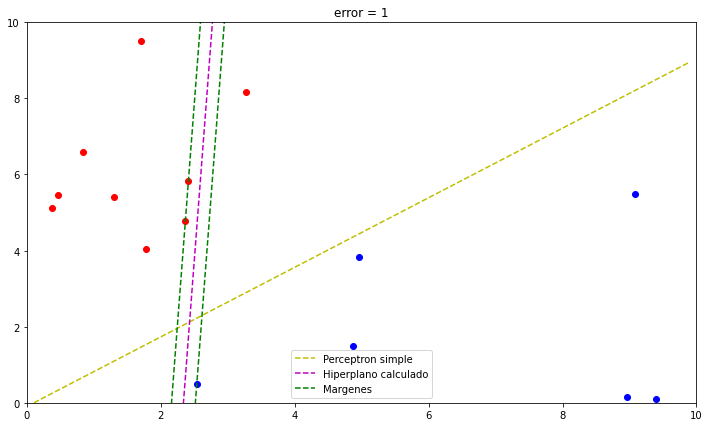

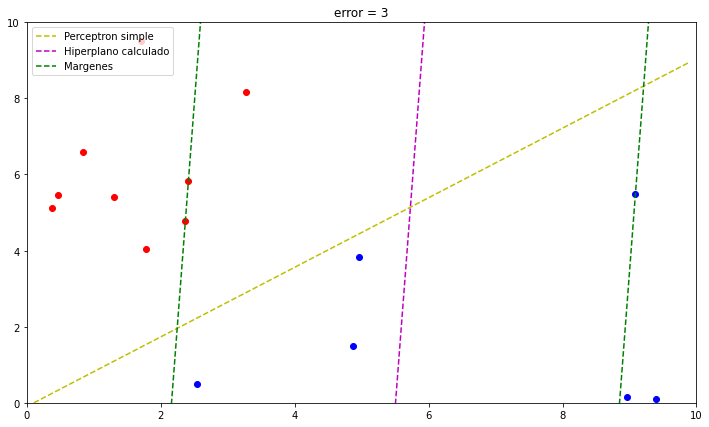

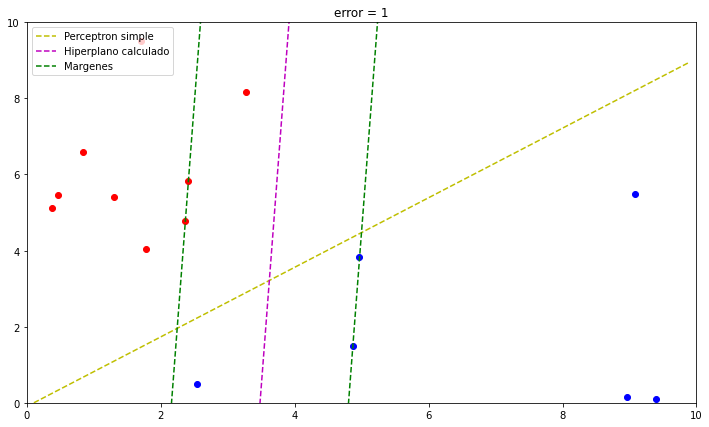

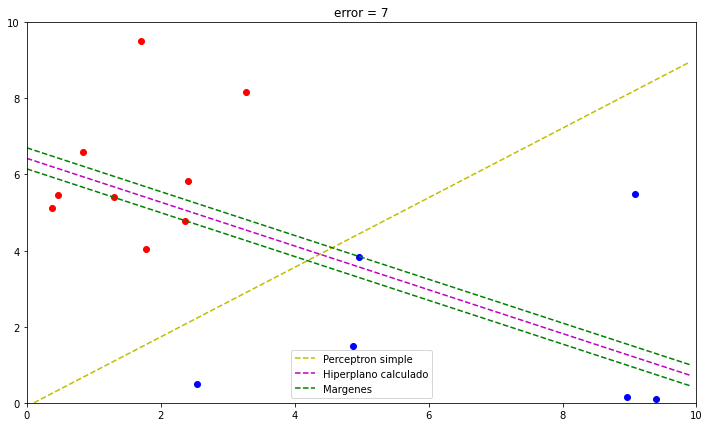

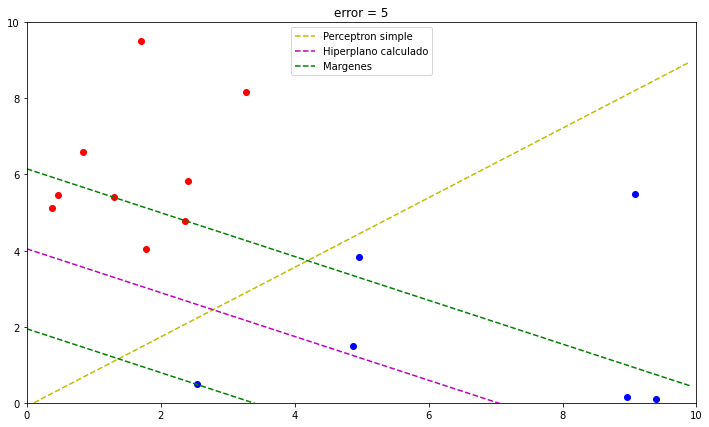

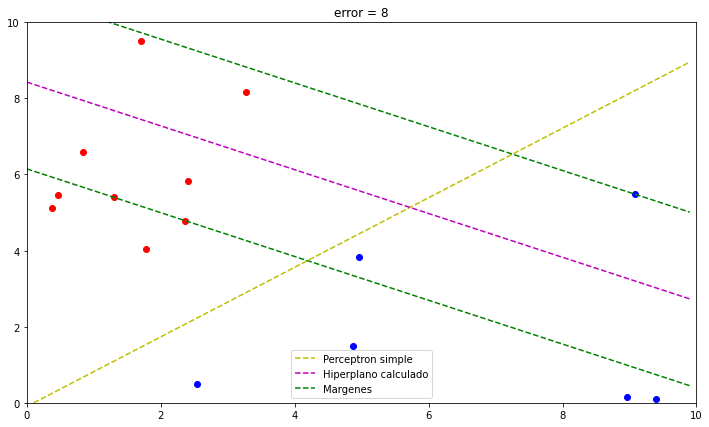

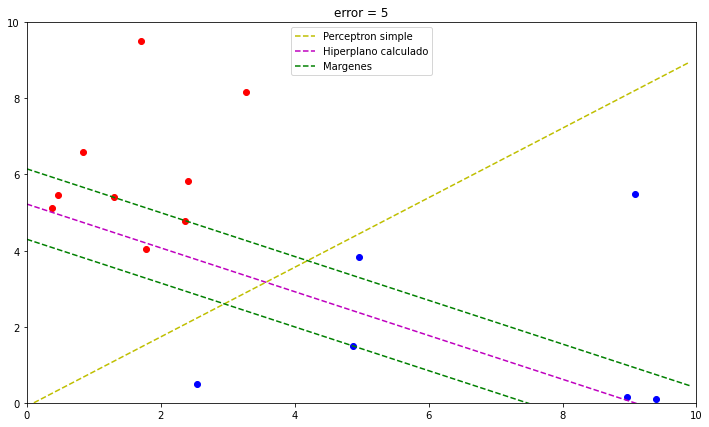

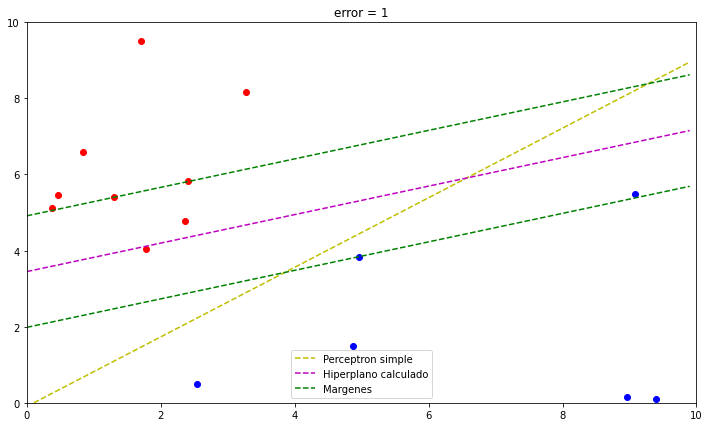

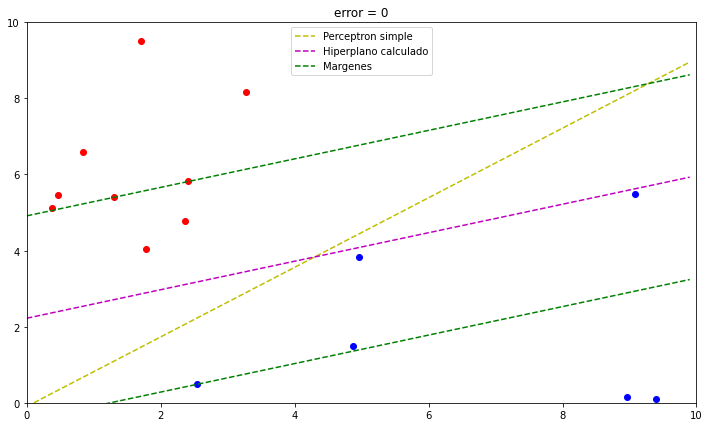

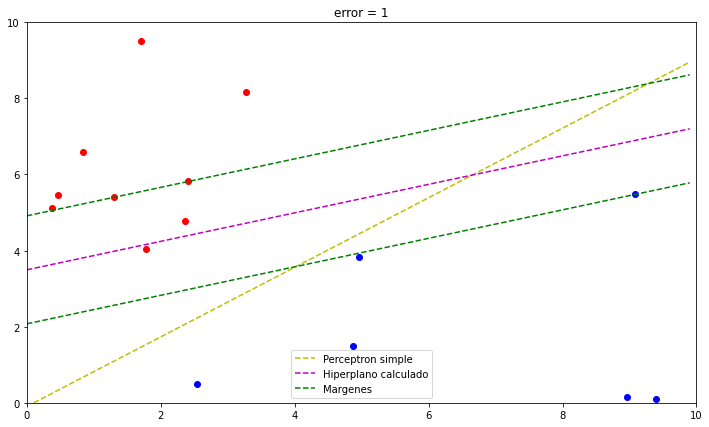

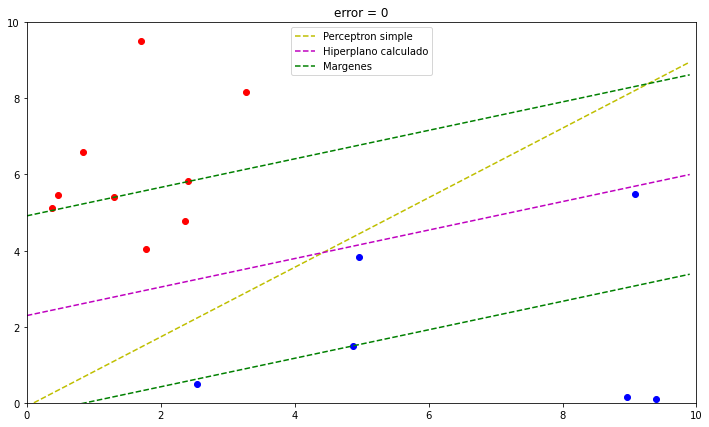

<Figure size 432x288 with 0 Axes>

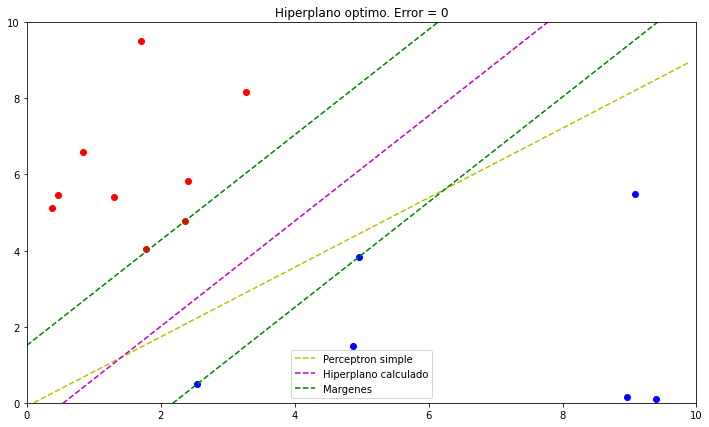

In [ ]:
k = 4
w_opt,w_margen_sup_opt,w_margen_inf_opt = hp_optimo(data1,w,k,x_vec,L)

###c) Construya el conjunto 'TP3-2' de forma análoga a como construyó el conjunto 'TP3-1' pero esta vez incluya algunos ejemplos que queden mal clasificados cerca del hiperplano de separación. Utilizar un perceptron simple para separar las dos clases. Comentar los resultados.

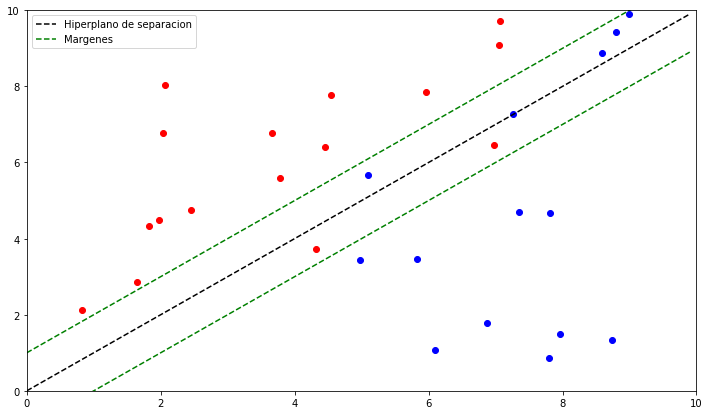

In [ ]:
#Creamos las dos clases
M2 = 1
L2 = 10
N2 = 30
x_vec2, y_hp2, m_sup2, m_inf2, data2 = crear_datos2(1,0,M2,L2,N2)
graficar_datos(L2, data2, x_vec2,True, y_hp2 ,True, m_sup2, m_inf2)

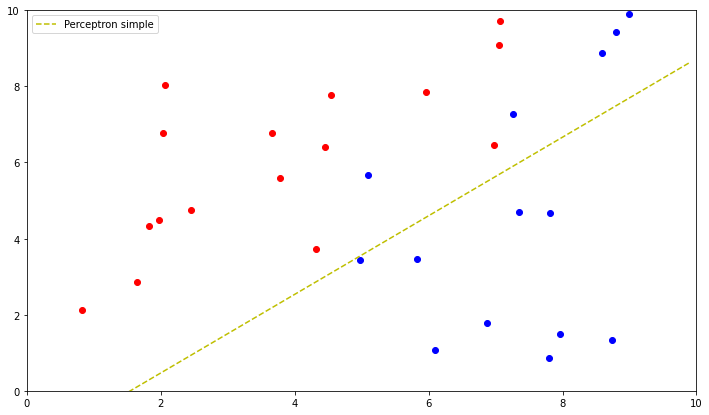

In [ ]:
#aplicamos el algoritmo perceptron simple
fp2 = 0.1
cota2 = 100*len(data2)
w2 = perceptron_simple(data2,fp2,cota2)
graficar_datos(L2, data2, x_vec2, per = True, w = w2)

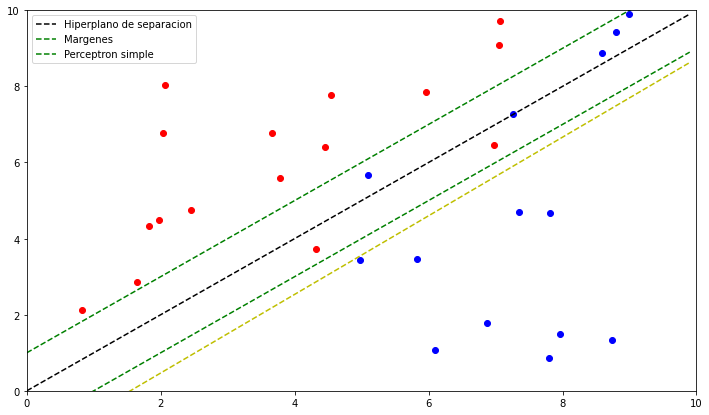

In [ ]:
#graficamos el hiperplano inicial y el hiperplano generado por perceptron simple
graficar_datos(L2, data2, x_vec2,True, y_hp2 ,True, m_sup2, m_inf2, per = True, w = w2)

###d) Utilice SVM para clasificar tanto el conjunto 'TP3-1' como el conjunto 'TP3-2'. Compare los resultados con los obtenidos en el punto a) y c).

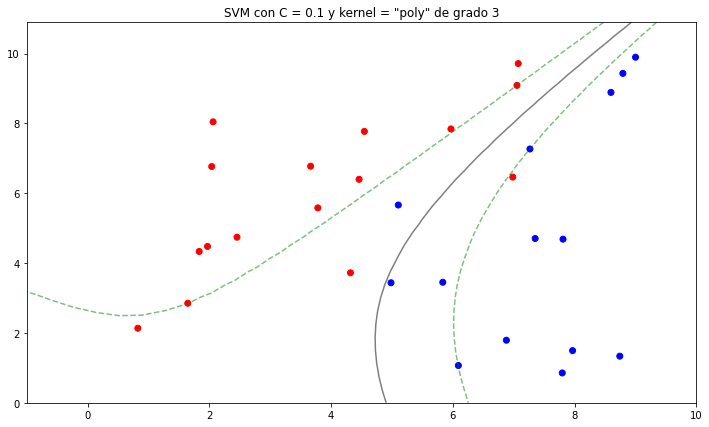

In [ ]:
C_svm1 = 0.1
f1 = fun_svm(data2,'poly',3,C_svm1, graficar_2D = True)

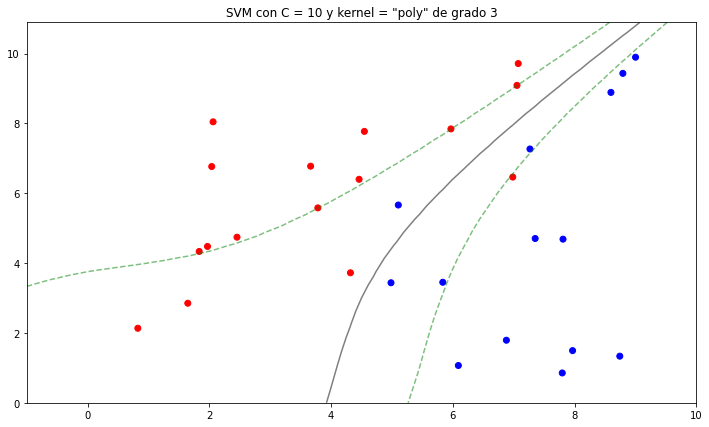

In [ ]:
C_svm2 = 10
f2 = fun_svm(data2,'poly',3,C_svm2, graficar_2D = True)

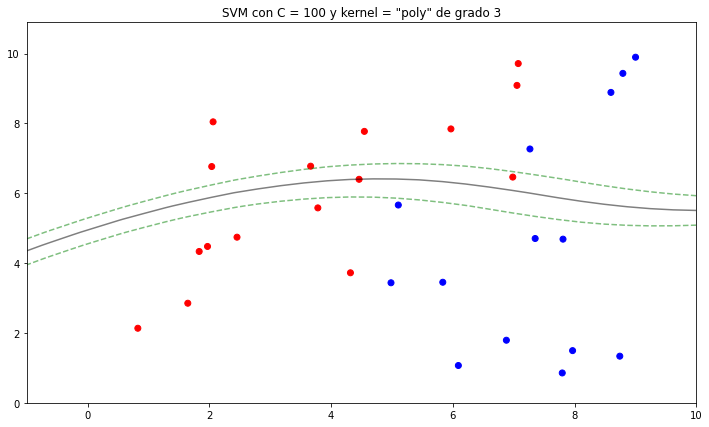

In [ ]:
C_svm3 = 100
f3 = fun_svm(data2,'poly',3,C_svm3, graficar_2D = True)

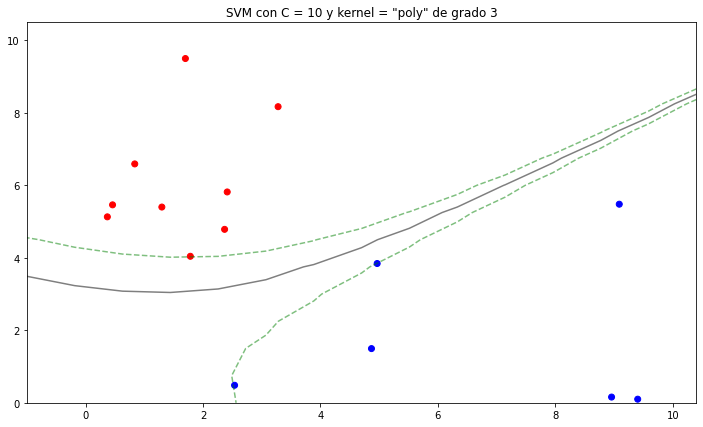

In [ ]:
C_svm4 = 10
f4 = fun_svm(data1,'poly',3,C_svm4, graficar_2D = True)

#Ejercicio 2



##Codigo

###Datos


In [ ]:
def crear_data3(vaca,cielo,pasto):
  data = pd.DataFrame(columns = ['R','G','B','clase'])
  a = [vaca,cielo,pasto]
  i = 0
  colores = [[],[],[]]
  clase = []
  for imagen in a:
    M, N, O = imagen.shape
    for m in range(M):
      for n in range(N):
        for o in range(O):
          colores[o].append(imagen[m,n,o])
        clase.append(i)
    i += 1 
  
  data.iloc[:,0] = colores[0]
  data.iloc[:,1] = colores[1]
  data.iloc[:,2] = colores[2]
  data.iloc[:,3] = clase

  return data

###Clasificador SVM

In [ ]:
def svm_3clases(train,test,matriz_confusion = False,kernel = 'rbf',grado_poly = 3,C = 1,max_iter = 1000):
  
  #Calculamos los distintos clasificadores y sus predicciones para las distintas combinaciones de clases
  vaca_cielo = train.loc[train['clase'] != 2]
  clasificador_vc = svm.SVC(C = C, kernel = kernel, degree = grado_poly, max_iter = max_iter)
  clasificador_vc = clasificador_vc.fit(vaca_cielo[['R','G','B']],vaca_cielo[['clase']].values.ravel())
  predicha_vc = clasificador_vc.predict(test[['R','G','B']])

  vaca_pasto = train.loc[train['clase'] != 1]
  clasificador_vp = svm.SVC(C = C, kernel = kernel, degree = grado_poly, max_iter = max_iter)
  clasificador_vp = clasificador_vp.fit(vaca_pasto[['R','G','B']],vaca_pasto[['clase']].values.ravel())
  predicha_vp = clasificador_vp.predict(test[['R','G','B']])

  cielo_pasto = train.loc[train['clase'] != 0]
  clasificador_cp = svm.SVC(C = C, kernel = kernel, degree = grado_poly, max_iter = max_iter)
  clasificador_cp = clasificador_cp.fit(cielo_pasto[['R','G','B']],cielo_pasto[['clase']].values.ravel())
  predicha_cp = clasificador_cp.predict(test[['R','G','B']])

  if matriz_confusion == False:
    #Aramamos una tabla con las distintas predicciones y las clases reales
    tabla_predicciones = pd.DataFrame(columns = ['predicha vc','predicha vp','predicha cp','predicha'])
    tabla_predicciones.iloc[:,0] = predicha_vc
    tabla_predicciones.iloc[:,1] = predicha_vp
    tabla_predicciones.iloc[:,2] = predicha_cp

    #Calculamos la prediccion final haciendo la moda de las predicciones. En el caso que todas sean distintas se elige una clase aleatoria
    predicha_final = []
    for i in range(len(test)):
      if len(np.unique([predicha_vc[i],predicha_vp[i],predicha_cp[i]])) == 3:
        predicha_final.append(np.random.randint(0,3))
      else:
        predicha_final.append(stats.mode([predicha_vc[i],predicha_vp[i],predicha_cp[i]])[0][0])
    tabla_predicciones.iloc[:,3] = predicha_final

    return tabla_predicciones

  else:
    #Aramamos una tabla con las distintas predicciones y las clases reales
    tabla_predicciones = pd.DataFrame(columns = ['real','predicha vc','predicha vp','predicha cp','predicha'])
    tabla_predicciones.iloc[:,0] = test['clase']
    tabla_predicciones.iloc[:,1] = predicha_vc
    tabla_predicciones.iloc[:,2] = predicha_vp
    tabla_predicciones.iloc[:,3] = predicha_cp

    #Calculamos la prediccion final haciendo la moda de las predicciones. En el caso que todas sean distintas se elige una clase aleatoria
    predicha_final = []
    for i in range(len(test)):
      if len(np.unique([predicha_vc[i],predicha_vp[i],predicha_cp[i]])) == 3:
        predicha_final.append(np.random.randint(0,3))
      else:
        predicha_final.append(stats.mode([predicha_vc[i],predicha_vp[i],predicha_cp[i]])[0][0])
    tabla_predicciones.iloc[:,4] = predicha_final

    #Calculamos la matriz de confusion columna predicho, fila real
    head = ['Vaca','Cielo','Pasto']
    matriz_confusion = pd.DataFrame(columns = head,index = head)
    matriz_confusion = matriz_confusion.fillna(0)

    for i in range(0,len(tabla_predicciones)):
      matriz_confusion.iloc[tabla_predicciones.iloc[i,0],tabla_predicciones.iloc[i,4]] += 1

    #Calculamos la precision metricas.loc[i,'Precision'] = tabla_VF.loc[i,'VP']/(tabla_VF.loc[i,'VP']+tabla_VF.loc[i,'FP'])
    VP = 0
    FP = 0
    for i in range(len(matriz_confusion)):
      for j in range(len(matriz_confusion)):
        if i == j: 
          VP += matriz_confusion.iloc[i,i]
        else:
          FP +=  matriz_confusion.iloc[i,j]

    precision = VP/(VP+FP)
    
    return tabla_predicciones,matriz_confusion,precision

###Imagen Clasificada

In [ ]:
def imagen_clases(imagen,train,kernel = 'rbf',grado_poly = 3,C = 1,max_iter = 1000):
  data_img = pd.DataFrame(columns = ['R','G','B'])
  colores = [[],[],[]]
  M, N, O = imagen.shape
  for m in range(M):
    for n in range(N):
      for o in range(O):
        colores[o].append(imagen[m,n,o])
  
  data_img.iloc[:,0] = colores[0]
  data_img.iloc[:,1] = colores[1]
  data_img.iloc[:,2] = colores[2]

  # Calculamos las predicciones para la imagen dada
  predicciones = svm_3clases(train,data_img,matriz_confusion = False,kernel = kernel,grado_poly = grado_poly,C = C,max_iter = max_iter)
  
  # Creamos la imagen para observar las clases
  imagen_clasificada = np.reshape(predicciones.iloc[:,3].values.ravel()+1, (imagen.shape[0], imagen.shape[1])) 
  colores = colors.ListedColormap(['brown','blue', 'green'])
  limites = [1,2,3,4]
  norm = colors.BoundaryNorm(limites, colores.N)

  #Imagen original
  plt.figure()
  plt.imshow(imagen, cmap=plt.cm.Greys_r)
  plt.title("Imagen original")
  
  # Imagen clasificada
  fig, ax = plt.subplots()
  ax.imshow(imagen_clasificada, cmap=colores, norm=norm)
  plt.title("Imagen por clases")

##Resolucion

###Segmentación de Imágenes en color:Considere la imagen cow.jpg y las imágenes muestra: vaca.jpg, cielo.jpg y pasto.jpg correspondientes a las clases dentro de la imagen \vaca", \cielo" y \pasto", respectivamente.

###a) Construir un conjunto de datos para entrenamiento, indicando para cada muestra a qué clase pertenece.

Text(0.5, 1.0, 'Pasto. Shape = (198, 208, 3)')

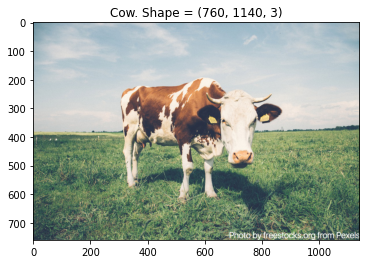

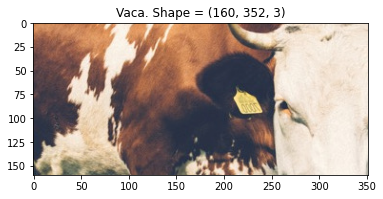

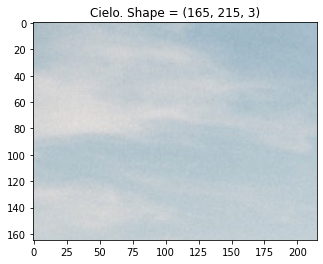

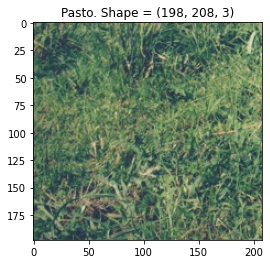

In [ ]:
cow = imread('/content/drive/Shareddrives/Machine Learning/TP3/cow.jpg')
vaca = imread('/content/drive/Shareddrives/Machine Learning/TP3/vaca.jpg')
cielo = imread('/content/drive/Shareddrives/Machine Learning/TP3/cielo.jpg')
pasto = imread('/content/drive/Shareddrives/Machine Learning/TP3/pasto.jpg')

plt.figure()
plt.imshow(cow, cmap=plt.cm.Greys_r)
plt.title("Cow. Shape = " + str(cow.shape))

plt.figure()
plt.imshow(vaca, cmap=plt.cm.Greys_r)
plt.title("Vaca. Shape = " + str(vaca.shape))

plt.figure()
plt.imshow(cielo, cmap=plt.cm.Greys_r)
plt.title("Cielo. Shape = " + str(cielo.shape))

plt.figure()
plt.imshow(pasto, cmap=plt.cm.Greys_r)
plt.title("Pasto. Shape = " + str(pasto.shape))

In [ ]:
data3 = crear_data3(vaca,cielo,pasto)
data3

R    G    B  clase
0       225  152   99      0
1       237  164  113      0
2       223  152  100      0
3       206  134   84      0
4       215  145   94      0
...     ...  ...  ...    ...
132974  130  150  101      2
132975  149  171  124      2
132976  133  154  111      2
132977  136  153  117      2
132978  129  149  121      2

[132979 rows x 4 columns]

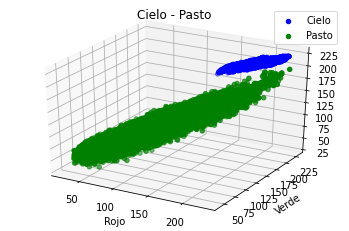

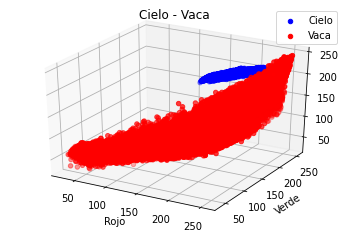

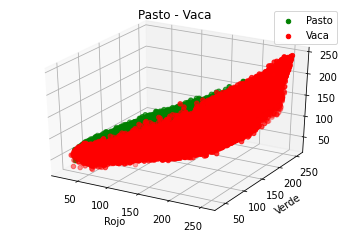

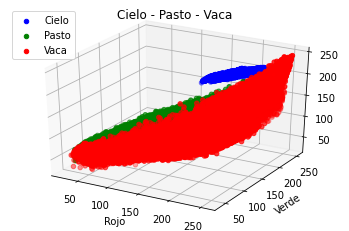

In [ ]:
fig = plt.figure() 
ax1 = fig.add_subplot(111, projection='3d') 

x_1 = np.asarray(data3.loc[data3['clase'] == 1,'R'].values)
y_1 = np.asarray(data3.loc[data3['clase'] == 1,'G'].values)
z_1 = np.asarray(data3.loc[data3['clase'] == 1,'B'].values)

x_2 = np.asarray(data3.loc[data3['clase'] == 2,'R'].values)
y_2 = np.asarray(data3.loc[data3['clase'] == 2,'G'].values)
z_2 = np.asarray(data3.loc[data3['clase'] == 2,'B'].values)

x_3 = np.asarray(data3.loc[data3['clase'] == 0,'R'].values)
y_3 = np.asarray(data3.loc[data3['clase'] == 0,'G'].values)
z_3 = np.asarray(data3.loc[data3['clase'] == 0,'B'].values)

ax1.scatter(x_1, y_1, z_1, c='b', marker='o', label='Cielo')
ax1.scatter(x_2, y_2, z_2, c='g', marker='o', label='Pasto')
plt.xlabel('Rojo')
plt.ylabel('Verde')
plt.legend(loc='best')
plt.title('Cielo - Pasto')
plt.show()

fig = plt.figure() 
ax2 = fig.add_subplot(111, projection='3d') 
ax2.scatter(x_1, y_1, z_1, c='b', marker='o', label='Cielo')
ax2.scatter(x_3, y_3, z_3, c='r', marker='o', label='Vaca')
plt.xlabel('Rojo')
plt.ylabel('Verde')
plt.legend(loc='best')
plt.title('Cielo - Vaca')
plt.show()

fig = plt.figure() 
ax3 = fig.add_subplot(111, projection='3d') 
ax3.scatter(x_2, y_2, z_2, c='g', marker='o', label='Pasto')
ax3.scatter(x_3, y_3, z_3, c='r', marker='o', label='Vaca')
plt.xlabel('Rojo')
plt.ylabel('Verde')
plt.legend(loc='best')
plt.title('Pasto - Vaca')
plt.show()

fig = plt.figure() 
ax4 = fig.add_subplot(111, projection='3d') 
ax4.scatter(x_1, y_1, z_1, c='b', marker='o', label='Cielo')
ax4.scatter(x_2, y_2, z_2, c='g', marker='o', label='Pasto')
ax4.scatter(x_3, y_3, z_3, c='r', marker='o', label='Vaca')
plt.xlabel('Rojo')
plt.ylabel('Verde')
plt.legend(loc='best')
plt.title('Cielo - Pasto - Vaca')
plt.show()

###b) Dividir aleatoriamente el conjunto de datos en dos conjuntos, uno de entrenamiento y uno de prueba.

In [ ]:
size_test = 0.3
test3,train3 = train_test_split(data3, train_size = size_test, random_state = 2)
train3

R    G    B  clase
90796   192  205  211      1
97817   114  150  104      2
1052    241  229  215      0
30360    72   62   71      0
77193   182  201  208      1
...     ...  ...  ...    ...
53414   233  223  211      0
107342  128  155  102      2
115781   48   76   64      2
2718    114   86   82      0
24433   139   87   66      0

[93086 rows x 4 columns]

In [ ]:
test3

R    G    B  clase
76558   179  196  204      1
101029   99  116   98      2
116676   63   92   70      2
63969   193  204  210      1
76977   179  198  205      1
...     ...  ...  ...    ...
33867   233  215  191      0
84434   196  205  210      1
95816   126  144  102      2
100879   75   87   65      2
89256   212  213  217      1

[39893 rows x 4 columns]

###c) Utilizar el método SVM para clasificar los pixels del conjunto de prueba, entrenando con el conjunto de entrenamiento. Utilizar diferentes núcleos y diferentes valores del parámetro C. Construir la matriz de confusión para cada caso.

####Nucleo lineal

In [ ]:
precisiones_totales = []#VP/(VP+VN)

In [ ]:
#C = 1 
tp1,mc1,p1 = svm_3clases(train3, test3, matriz_confusion = True, kernel = 'linear', C = 1, max_iter=100000)
precisiones_totales.append(p1)
print('precision = ',p1)
mc1

precision =  0.7475496954352894


Vaca  Cielo  Pasto
Vaca   9627   3845   3511
Cielo     0  10628      0
Pasto  2715      0   9567

In [ ]:
#C = 100
tp2,mc2,p2 = svm_3clases(train3, test3, matriz_confusion = True, kernel = 'linear', C = 100, max_iter=100000)
precisiones_totales.append(p2)
print('precision = ',p2)
mc2

precision =  0.6508409996741283


Vaca  Cielo  Pasto
Vaca   8022   3845   5116
Cielo     0  10628      0
Pasto  4968      0   7314

In [ ]:
#C = 1000
tp3,mc3,p3 = svm_3clases(train3, test3, matriz_confusion = True, kernel = 'linear', C = 1000, max_iter=100000)
precisiones_totales.append(p3)
print('precision = ',p3)
mc3

precision =  0.7030556739277567


Vaca  Cielo  Pasto
Vaca   6345   4062   6576
Cielo     0  10628      0
Pasto  1208      0  11074

####Nucleo polinomico

In [ ]:
#C = 1, degree = 3
tp4,mc4,p4 = svm_3clases(train3, test3, matriz_confusion = True, kernel = 'poly', grado_poly = 3, C = 1, max_iter=100000)
precisiones_totales.append(p4)
print('precision = ',p4)
mc4

precision =  0.9874414057604091


Vaca  Cielo  Pasto
Vaca   16758      1    224
Cielo      0  10628      0
Pasto    276      0  12006

In [ ]:
#C = 1, degree = 5
tp5,mc5,p5 = svm_3clases(train3, test3, matriz_confusion = True, kernel = 'poly', grado_poly = 5, C = 1, max_iter=100000)
precisiones_totales.append(p5)
print('precision = ',p5)
mc5

precision =  0.8635349560073196


Vaca  Cielo  Pasto
Vaca   12183   2270   2530
Cielo    242  10386      0
Pasto    229    173  11880

In [ ]:
#C = 100, degree = 3
tp6,mc6,p6 = svm_3clases(train3, test3, matriz_confusion = True, kernel = 'poly', grado_poly = 3, C = 100, max_iter=100000)
precisiones_totales.append(p6)
print('precision = ',p6)
mc6

precision =  0.8995061790289023


Vaca  Cielo  Pasto
Vaca   13667    509   2807
Cielo      0  10628      0
Pasto    693      0  11589

In [ ]:
#C = 100, degree = 5
tp7,mc7,p7 = svm_3clases(train3, test3, matriz_confusion = True, kernel = 'poly', grado_poly = 5, C = 100, max_iter=100000)
precisiones_totales.append(p7)
print('precision = ',p7)
mc7

precision =  0.8021457398541098


Vaca  Cielo  Pasto
Vaca   11440    471   5072
Cielo      0  10628      0
Pasto   2350      0   9932

####Nucleo rbf

In [ ]:
#C = 1
tp8,mc8,p8 = svm_3clases(train3, test3, matriz_confusion = True, kernel = 'rbf' ,C = 1 , max_iter = 100000)
precisiones_totales.append(p8)
print('precision = ',p8)
mc8

precision =  0.9876168751410022


Vaca  Cielo  Pasto
Vaca   16709      0    274
Cielo      0  10628      0
Pasto    220      0  12062

In [ ]:
#C = 100
tp9,mc9,p9 = svm_3clases(train3, test3, matriz_confusion = True, kernel = 'rbf', C=100, max_iter=100000)
precisiones_totales.append(p9)
print('precision = ',p9)
mc9 

precision =  0.9880179480109292


Vaca  Cielo  Pasto
Vaca   16708      0    275
Cielo      0  10628      0
Pasto    203      0  12079

In [ ]:
#C = 1000
tp10,mc10,p10 = svm_3clases(train3, test3, matriz_confusion = True, kernel = 'rbf', C=1000, max_iter=10000)
precisiones_totales.append(p10)
print('precision = ',p10)
mc10

precision =  0.9875667410322613


Vaca  Cielo  Pasto
Vaca   16659      0    324
Cielo      0  10628      0
Pasto    172      0  12110

###d) ¿Cuál es el núcleo que da mejores resultados? Pensar una justificación teórica para la respuesta.

In [ ]:
max_pre = max(precisiones_totales)
max_pre_index = precisiones_totales.index(max_pre)

print("La precision maxima es",max_pre)
print("El numero de la precision maxima es",max_pre_index+1)

La precision maxima es 0.9880179480109292
El numero de la precision maxima es 9


###e) Con el mismo método ya entrenado clasificar todos los pixels de la imagen.

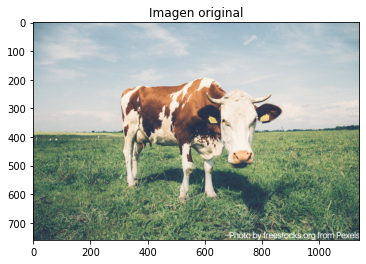

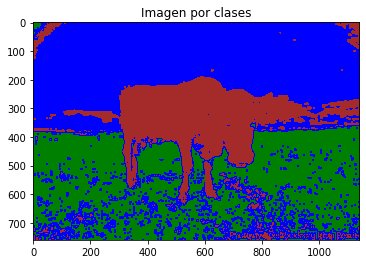

In [ ]:
imagen_clases(cow,data3,kernel = 'rbf',C = 100,max_iter = 100000)

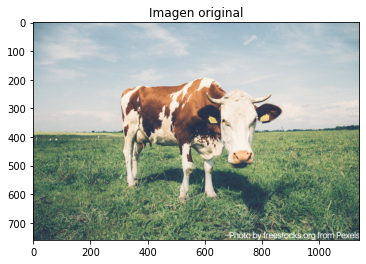

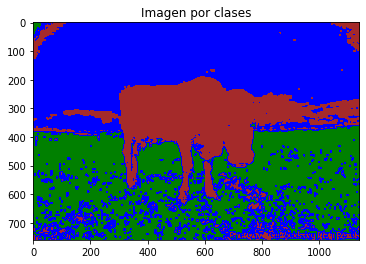

In [ ]:
imagen_clases(cow,data3,kernel = 'rbf',C = 1000,max_iter = 100000)

###f) Con el mismo método ya entrenado clasificar todos los pixels de otra imagen.

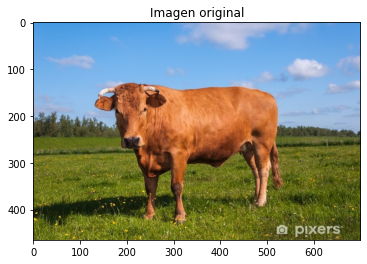

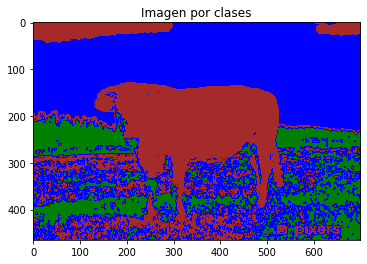

In [ ]:
nueva_imagen = imread('/content/drive/Shareddrives/Machine Learning/TP3/vacatp.jpeg')

imagen_clases(nueva_imagen,data3,kernel = 'rbf',C = 1000,max_iter = 100000)